In [873]:
# Library
import os
import numpy as np
from numpy.random import randint
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img, img_to_array, array_to_img

# Set path
%cd C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project2

C:\Users\user\Desktop\KUL - Mstat\Big Data Platforms and Technologies\project2


**<font color='blue'>The second part of your lab report should contain:</font>**
- <font color='blue'>Overview of your full deep learning pipe line, including architecture, trade-offs, ways used to prevent overfitting</font>
- <font color='blue'>Results based on your chosen evaluation metric</font>
- <font color='blue'>Illustration of your model's predictions on a test image (or one of your own)</font>
- <font color='blue'>Style points if you test out your model on a picture of your own (e.g. using FastAPI / Shiny / Flask / …)</font>
- <font color='blue'>Style points if you apply some interpretability techniques</font>
- <font color='blue'>You don’t need a beefy machine / GPU! Downscale images, use transfer learning with a pretrained model / image augmentation, ...</font>

In [652]:
# Read guideline
receipes = pd.read_csv(os.getcwd() + r'\\recipes.csv', sep = ';')
# Read tag
tag = pd.read_table(os.getcwd() + r'\\tag_merge.txt', sep = ',', header = None, skipinitialspace=True)

In [653]:
receipes.head(3)

,photo_id,url,may_be,likes,timestamp,scraped_at,diff,tag_healthy,tag_tasty,tag_dinner,...,tag_egg,tag_oatmeal,tag_natural,tag_beef,tag_noodles,tag_italian,tag_drinks,tag_steak,tag_sandwich,tag_strawberry
0,CMPELQqh_nh,https://www.instagram.com/p/CMPELQqh_nh/,dessert and indoor,3,2021-03-10T10:47:18,2021-03-10T11:48:52,1.03,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,CMPEHqppR-t,https://www.instagram.com/p/CMPEHqppR-t/,pasta and indoor,3,2021-03-10T10:46:48,2021-03-10T11:48:59,1.04,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CMPEBY9Buko,https://www.instagram.com/p/CMPEBY9Buko/,cake and indoor,2,2021-03-10T10:45:57,2021-03-10T11:49:08,1.05,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [654]:
# Transform tag's into a dictionary {'old tag': 'new tag'}
newheader = tag[0]
tag_dict = tag.T.iloc[[1]]
tag_dict.columns = newheader.values
tag_dict = tag_dict.T.to_dict()[1]

In [672]:
len(tag_dict)

55

<font color='red'>There seems to be too many labels...</font>

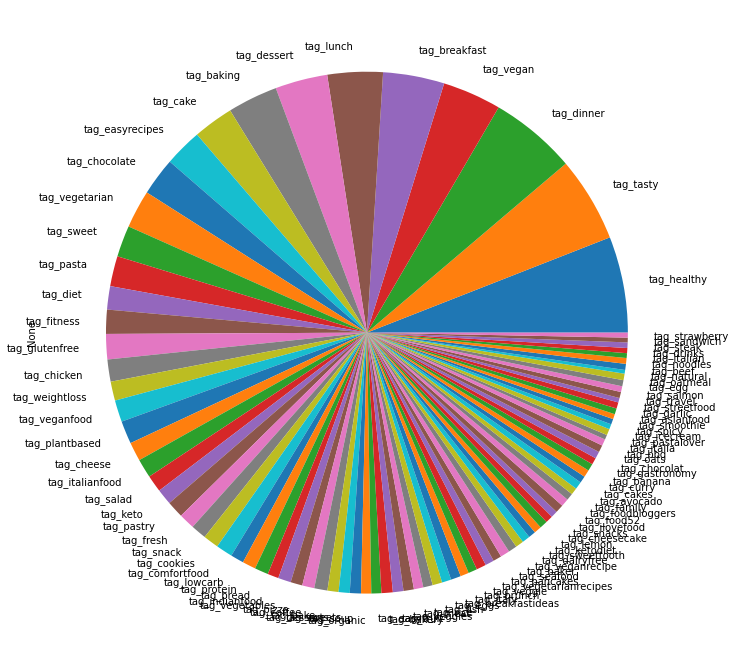

In [7]:
# Class distribution
column_tag = receipes.columns.to_series().str.startswith('tag_')
column_tag = receipes.columns[column_tag]
receipes[column_tag].sum().plot.pie(figsize = (12, 12))

<font color='red'>Image processing </font>

In [50]:
# Load data
def load_data(IMGSIZE):
    images, labels = list(), list()
    for ind, photo_id in enumerate(receipes['photo_id']):
        # In case of empty image, load_img() gives warnings, use try except here
        try:
            IMGPATH = r'\recipes\recipes' + '\\' + photo_id + '.png'
            image = load_img(os.getcwd() + IMGPATH, target_size = IMGSIZE)
            label = receipes.iloc[ind][column_tag] == 1
            images.append(img_to_array(image))
            labels.append(column_tag[label])
        except: 
            continue
    return images, labels

In [51]:
%%time
# (224, 224) for ResNet50V2 and VGG16
# It may take a while to run
IMGSIZE = (224, 224)
X, y = load_data(IMGSIZE)

<font color='red'>Randomly show you some images</font>

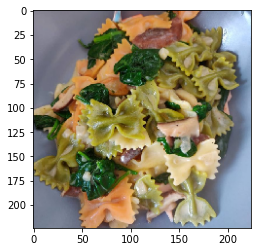

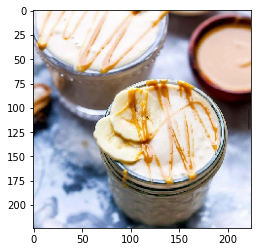

In [68]:
N = len(X)
rand_indices = randint(0, N, size = 2)
for ind in rand_indices:
    plt.imshow(array_to_img(X[ind]))
    plt.show()

<font color='red'>Too many labels, regroup them</font>

In [804]:
# Some tag are unrelated to types of food
drop_tag = ['tag_easyrecipes', 'tag_ilovefood', 'tag_food52', 'tag_foodbloggers', 'tag_family',
           'tag_glutenfree', 'tag_easy']

In [805]:
# Each element of yn contains a list of tags with nonzero values
def map_tag(tags):
    tag_merged = set()
    for tag in tags:
        if tag in tag_dict.keys():
            tag_merged.add(tag_dict[tag])
        elif tag not in drop_tag:
            tag_merged.add(tag)
    return list(tag_merged)
yn = [map_tag(tags) for tags in y]

In [821]:
# Update column names: Drop names appeared in drop_tag, group names tgt using tag_dict
new_labels = column_tag.drop(drop_tag).to_series().replace(tag_dict).values

In [858]:
# Convert each element of yn into an array using dictionary as mapping
def get_dict(tags):
    dict_temp = dict()
    for new_label, exist in zip(new_labels, [0] * len(new_labels)):
        if new_label in tags:
            exist = 1
        dict_temp[new_label] = exist
    return dict_temp
y_np = pd.DataFrame([get_dict(tags) for tags in yn]).to_numpy()

<font color='red'>Randomly sample some images given tag, some may look weird</font>

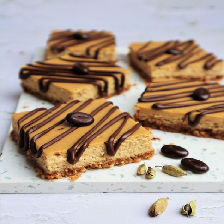

In [820]:
# Check some concepts
photo_id = receipes[receipes['tag_easy'] == 1].sample(1)['photo_id'].values[0]
IMGPATH = r'\recipes\recipes' + '\\' + photo_id + '.png'
load_img(os.getcwd() + IMGPATH, target_size = IMGSIZE)

In [803]:
# How many image belongs to such tag?
TAG = 'tag_easy'
receipes[receipes[TAG] == 1].shape[0]

148

--- 

<font color='red'> Rescaling & Train-test split</font>

In [872]:
# Rescaling input
X = np.array(X)/255

In [874]:
%%time 
# Train:Val:Test = 0.7:0.2:0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 721)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 2/9, random_state = 831)